# Эксперименты по выявлению ключевых аспектов в текстовых отзывах на основе отзывов с сервиса Яндекс.Карты


In [1]:
import pandas as pd
import re
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/data/geo-reviews-dataset-2023.tskv', sep="\t", header=None)

Источник данных: https://github.com/yandex/geo-reviews-dataset-2023/blob/master/README.md

## Обработка данных

In [ ]:
# посмотрим, как выглядит исходные данные
df[:3]

,0,1,2,3,4
0,"address=Екатеринбург, ул. Московская / ул. Вол...",name_ru=Московский квартал,rating=3.,rubrics=Жилой комплекс,text=Московский квартал 2.\nШумно : летом по н...
1,"address=Московская область, Электросталь, прос...",name_ru=Продукты Ермолино,rating=5.,rubrics=Магазин продуктов;Продукты глубокой за...,"text=Замечательная сеть магазинов в общем, хор..."
2,"address=Краснодар, Прикубанский внутригородско...",name_ru=LimeFit,rating=1.,rubrics=Фитнес-клуб,"text=Не знаю смутят ли кого-то данные правила,..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       500000 non-null  object
 1   1       500000 non-null  object
 2   2       500000 non-null  object
 3   3       500000 non-null  object
 4   4       499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


In [ ]:
df.columns = ['Адрес организации', 'Название организации', 'Рейтинг', 'Рубрика', 'Отзыв']  # добавляем названия столбцов
# убираем метки в начале каждой ячейки:
df = df.map(lambda x: re.sub(r'[a-z_]+=', '', x) if isinstance(x, str) else x)
# проверяем, является ли содержимое ячейки строкой, т.к. в df есть NaN

В последнем столбце есть 970 пустых значений. Посмотрим, как выглядят данные в этих строчках.

In [ ]:
null_reviews = df[df['Отзыв'].isnull()]
null_reviews.head()

,Адрес организации,Название организации,Рейтинг,Рубрика,Отзыв
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",5.,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе...",NaN
5716,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Гостиница действительно хорошая, удобно распол...",NaN
5717,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,Был здесь на кулинарном мастер-классе. Место а...,NaN
5718,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Тихое место, в выходные возможно и шумно так к...",NaN
5719,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к...",NaN


Можно предположить, что во всех этих строках отсутствует название организации, из-за чего последующие столбцы сдвинулись влево и последний столец получился пустым. Проверим эту гипотезу:

In [ ]:
len(null_reviews) == len(null_reviews['Название организации'].str.contains('\d\.', regex=True))

True

В этом проекте название организации не имеет значения, нам нужен только отзыв из выбранной рубрики. Восстановим структуру датафрейма так, чтобы пропущенные значения были в названии организации, а не в отзыве.

In [ ]:
null_reviews.loc[:, 'Отзыв'] = null_reviews['Рубрика']
null_reviews.loc[:, 'Рубрика'] = null_reviews['Рейтинг']
null_reviews.loc[:, 'Рейтинг'] = null_reviews['Название организации']
null_reviews.loc[:, 'Название организации'] = np.nan

In [ ]:
null_organization_names = null_reviews.copy()

In [ ]:
# заменим смещенные строчки в исходном датафрейме:
df[df['Отзыв'].isnull()] = null_organization_names

In [ ]:
# уберём точки в столбце с рейтингом:
df['Рейтинг'] = df['Рейтинг'].str.replace('.', '')

In [ ]:
df.info()  # структура восстановлена, все данные сохранены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Адрес организации     500000 non-null  object
 1   Название организации  499030 non-null  object
 2   Рейтинг               500000 non-null  object
 3   Рубрика               500000 non-null  object
 4   Отзыв                 500000 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


В этом проекте мы будем анализировать отзывы о кофейнях.

In [ ]:
# выбираем нужную рубрику:
data = df[df['Рубрика'].str.contains('Кофейня', case=False)]

In [ ]:
# посмотрим, сколько отзывов в выбранной рубрике:
len(data)

10531

In [ ]:
# создадим отдельный датафрейм с отзывами только о кофейнях
reviews_df = data['Отзыв'].copy().reset_index(drop=True)

In [ ]:
reviews = reviews_df.tolist()  # список отзывов

In [ ]:
# очистим отзывы от лишних символов и пробелов:
clean_reviews = []

for review in reviews:
  review = re.sub('\\\\n', ' ', review)
  review = re.sub(r'\s{2,}', ' ', review)
  clean_reviews.append(review.strip())

## Сетимент-анализ отзывов с помощью [RuBERT for Sentiment Analysis](https://huggingface.co/blanchefort/rubert-base-cased-sentiment)
Labels  
0: NEUTRAL  
1: POSITIVE  
2: NEGATIVE  

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
sentiment_model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True).to(device)

In [ ]:
def predict(text):
  inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
  outputs = sentiment_model(**inputs)
  predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
  if (predicted > 0.8).any():  # отбираем отзывы, в которых нейросеть уверена на более, чем 80%
    predicted_label = torch.argmax(predicted, dim=1).cpu().numpy()
  else:
    predicted_label = np.array([0])  # остальные относим к нейтральным
  return predicted_label

In [ ]:
from torch.utils.data import DataLoader
data_loader = DataLoader(clean_reviews, batch_size=16)

In [ ]:
from tqdm import tqdm

In [ ]:
sentiment_labels = []

with torch.no_grad():

  for batch in tqdm(data_loader):
    labels = predict(batch)
    sentiment_labels.extend(labels)

100%|██████████| 659/659 [01:42<00:00,  6.41it/s]


In [ ]:
sentiment_labels = np.array(sentiment_labels)

In [ ]:
# сортируем отзывы по индексам
positive_reviews_indexes = np.where(sentiment_labels == 1)[0]
negative_reviews_indexes = np.where(sentiment_labels == 2)[0]

In [ ]:
positive_reviews = [clean_reviews[i] for i in positive_reviews_indexes]
negative_reviews = [clean_reviews[i] for i in negative_reviews_indexes]

In [ ]:
len(positive_reviews), len(negative_reviews)  # смотрим количество отзывов

(8931, 966)

In [ ]:
# конвертируем размеченные отзывы в датафрейм и далее сохраним в csv-файл
positive_reviews_df = pd.DataFrame(positive_reviews, columns=['Отзыв'])
negative_reviews_df = pd.DataFrame(negative_reviews, columns=['Отзыв'])

In [ ]:
positive_reviews_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_reviews.csv')
negative_reviews_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_reviews.csv')

## Частотный анализ и извлечение ключевых n-грамм из отзывов

### Нормализация данных

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_ru = stopwords.words('russian')
from pymystem3 import Mystem
mystem = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# загрузим сгруппированные на предыдущем этапе отзывы:
positive_reviews_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_reviews.csv', index_col=0)
negative_reviews_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_reviews.csv', index_col=0)

Так как в отзывах нам важно выделять негативные конструкции, часто содержащие частицу 'не', удалим эту частицу из списка стоп-слов. Также мы будем выделять из негативных отзывов только триграммы, а не биграммы, чтобы лучше понимать смысл (любое слово с 'не' - это уже биграмма, которую без контекста часто сложно интерпретировать).

In [ ]:
# определим список стоп-слов:
stops = set(stopwords_ru + ['это', 'этого', 'как', 'чтобы', 'через', 'чем', 'весь', 'некоторый', 'который', 'просто',
                            'свой', 'поэтому', 'оказываться', 'самый', 'вроде', 'зато', 'хотя', 'наш', 'данный',
                            'мочь', 'однажды', 'что', 'то', 'однако', 'вскоре', 'приходиться', 'происходить',
                            'становиться', 'каждый', 'из', 'за', 'пока', 'хотеть', 'кажется', 'снова', 'никто',
                            'ничто', 'никак', 'делать', 'нужно', 'сделать', 'иметь', 'ради', 'очень', 'некий',
                            'вместо','сразу', 'бывать', 'весьма', 'менее', 'нибудь', 'никакой', 'немного','прежде',
                            'сей', 'туда', 'одновременно','кто', 'чей', 'среди', 'лишь', 'кроме', 'либо', 'нечто',
                            'сказать', 'наступать', 'кое-что','что-то', 'из-за', 'когда-нибудь', 'когда-то',
                            'что-либо', 'какой-то', 'кто-то', 'любой', 'по', 'твой', 'ваш', 'коль', 'пусть',
                            'всюду', 'подо', 'чей-то', 'как-нибудь', 'кто-нибудь', 'куда-то', 'из-под', 'где-то',
                            'как-то', 'тут-то', 'что-нибудь', 'почему', 'спустя', 'являться', 'сюда', 'ввиду', 'вообще',
                            'вполне', 'практически', 'марина', 'отзыв', 'спасибо', 'пожалуйста', 'руб', 'именно',
                            'совершенно', 'итог', 'особенно', 'лп', 'сочи', 'скуратов', 'абсолютно'])  - {'не'}

In [ ]:
# определим функцию нормализации текста:
def normalize(text):
    normalized_list =[token for token in mystem.lemmatize(text.lower()) if token not in stops]
    normalized_text = ' '.join(normalized_list)
    tidy_text = re.sub(r'[^а-яё ]', '', normalized_text)
    tidy_text = re.sub(r'\s{2,}', ' ', tidy_text)
    tidy_text = tidy_text.strip()

    return tidy_text

In [ ]:
# нормализуем отзывы
pos_lemmas_df = positive_reviews_df['Отзыв'].apply(normalize)
neg_lemmas_df = negative_reviews_df['Отзыв'].apply(normalize)

In [ ]:
# переименуем столбец с леммами
pos_lemmas_df.name, neg_lemmas_df.name = 'Леммы отзыва', 'Леммы отзыва'

In [ ]:
# чтобы отфильтровать общие фразы, создадим дополнительно список с ними:
general_phrases = ['оставлять желать хороший', 'не советовать заведение', 'возвращаться не хотеться',
                   'не рекомендовать заведение', 'несколько год назад', 'высоко всякий похвала',
                   'хороший кофейня', 'прекрасный место', 'рекомендовать посещение', 'приятно проводить время',
                   'выпивать чашечка кофе', 'добрый время сутки', 'добрый день', 'сегодня', 'жалко потратить деньги',
                   'зайти купить кофе', 'место не советовать', 'молодой человек', 'отличный место', 'хороший место',
                   'прийти не советовать', 'кофе приходить попить', 'заказывать кофе', 'любимый кофейня',
                   'прекрасный заведение отдыхать', 'ребята молодец', 'милый приятный кафе',
                   'категорически не рекомендовать', 'кафе не рекомендовать', 'приходить кафе', 'не хотеться приходить',
                   'зайти выпивать кофе', 'приходить утро', 'посещать кофейня', 'прекрасный кофейня',
                   'отличный кофейня', 'приятный место', 'выпивать кофе', 'отличный кафе', 'попить кофе',
                   'брать кофе', 'пить кофе', 'посещать кафе', 'чашечка кофе', 'прекрасный кафе', 'заходить кофе',
                   'кофе пробовать', 'хороший заведение', 'замечательный кафе', 'взять кофе', 'любимый место',
                   'любимая кофейня', 'приятный заведение', 'приятно посидеть', 'превосходный заведение']
# общие фразы выявлены на основе анализа самых частотных фраз, их мы увидем ниже

In [ ]:
def filter_general_phrases(df):

  for phrase in general_phrases:
    df = df.str.replace(phrase, '')
  filtered_df = df.str.replace(r'\s{2,}', ' ', regex=True)
  filtered_df = filtered_df.str.strip()

  return(filtered_df)

In [ ]:
pos_lemmas_df = filter_general_phrases(pos_lemmas_df)
neg_lemmas_df = filter_general_phrases(neg_lemmas_df)

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv_bigram = CountVectorizer(ngram_range=(2,2))  # для позитивных отзывов - биграммы
cv_trigram = CountVectorizer(ngram_range=(3, 3))  # для негативных - триграммы

In [4]:
# определяем, как будем извлекать отсортированные n-граммы
def get_main_aspects(text_df, cv):

  X = cv.fit_transform(text_df)
  ngrams = cv.get_feature_names_out()
  counts = X.toarray().sum(axis=0)
  ngram_counts = list(zip(ngrams, counts))
  ngram_counts_sorted = sorted(ngram_counts, key=lambda x: x[1], reverse=True)  # сортируем по убыванию частоты

  return(ngram_counts_sorted)

In [ ]:
# извлекаем биграммы из позитивных отзывов
pos_bigrams = get_main_aspects(pos_lemmas_df, cv_bigram)

In [ ]:
# а теперь - триграммы из позитивных и негативных отзывов
pos_trigrams = get_main_aspects(pos_lemmas_df, cv_trigram)  # позитивные триграммы дополнят контекст биграмм

In [ ]:
neg_trigrams = get_main_aspects(neg_lemmas_df, cv_trigram)

In [ ]:
# для последующего анализа оставим топ-100 n-грамм
main_positive_bigrams = pd.DataFrame(pos_bigrams[:100], columns=['CV биграммы', 'частота'])
main_positive_trigrams = pd.DataFrame(pos_trigrams[:100], columns=['CV триграммы', 'частота'])

In [ ]:
main_negative_trigrams = pd.DataFrame(neg_trigrams[:100],  columns=['CV триграммы', 'частота'])

In [ ]:
# объединим позитивные n-граммы в один датафрейм
main_positive_aspects_df = pd.concat([main_positive_bigrams, main_positive_trigrams], axis=1)
main_negative_aspects_df = main_negative_trigrams

Простой частотный анализ довольно хорошо справился с задачей вявления ключевых аспектов отзывов при условии хорошей предобработки. Попробуем также другие инструменты для решения этой задачи и в конце сравним результаты.

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_bigram = TfidfVectorizer(ngram_range=(2,2))  # для позитивных отзывов
tfidf_trigram = TfidfVectorizer(ngram_range=(3,3))  # для негативных отзывов

In [ ]:
# определим, как будет получать отсортированные списки ключевых n-грамм
def get_tfidf_keys(text_df, tfidf):
  X = tfidf.fit_transform(text_df)
  ngrams = tfidf.get_feature_names_out()
  counts = X.toarray().sum(axis=0)  # суммируем значения TF-IDF
  ngram_counts = list(zip(ngrams, counts))  # собираем список кортежей из ключей и их значений TF-IDF
  ngram_counts_sorted = sorted(ngram_counts, key=lambda x: x[1], reverse=True)  # сортируем по убыванию значения TF-IDF
  return(ngram_counts_sorted)

In [ ]:
# получим ключи для позитивных отзывов
pos_tfidf_trigrams = get_tfidf_keys(pos_lemmas_df, tfidf_bigram)

In [ ]:
# а теперь для негативных
neg_tfidf_trigrams = get_tfidf_keys(neg_lemmas_df, tfidf_trigram)

In [ ]:
# соберем топ-100 ключей и их суммарных значений TF-IDF в датафреймы
main_positive_tfidf_trigrams  = pd.DataFrame(pos_tfidf_trigrams[:100],  columns=['TF-IDF биграммы', 'показатель'])

In [ ]:
main_negative_tfidf_trigrams = pd.DataFrame(neg_tfidf_trigrams[:100],  columns=['TF-IDF триграммы', 'показатель'])

In [ ]:
# соединим результаты TF-IDF с результатами CountVectorizer в один датафрейм
main_positive_aspects_df = pd.concat([main_positive_aspects_df, main_positive_tfidf_trigrams], axis=1)

In [ ]:
main_negative_aspects_df = pd.concat([main_negative_aspects_df, main_negative_tfidf_trigrams], axis=1)

### RAKE

In [ ]:
pip install rake-nltk

In [ ]:
from rake_nltk import Rake
import nltk
nltk.download('punkt_tab')

In [ ]:
# определим, как будем извлекать ключи
def extract_key_phrases(text, top_n=100):

  r = Rake(min_length=1, max_length=3, include_repeated_phrases=False)
  # так как RAKE выделяет не большое количество n-грамм (менее 100), возьмём 1-3 слов в n-грамме
  r.extract_keywords_from_text(text)
  return r.get_ranked_phrases()[:top_n]

In [ ]:
# в RAKE нужно подавать сразу весь текст отзывов
pos_lemmas_text = '. '.join(pos_lemmas_df.tolist())
neg_lemmas_text = '. '.join(neg_lemmas_df.tolist())

In [ ]:
# извлекаем ключи и сразу собираем их в датафрейм
main_negative_rake_ngrams = pd.DataFrame(extract_key_phrases(neg_lemmas_text), columns=['RAKE n-граммы'])

In [ ]:
main_positive_rake_ngrams = pd.DataFrame(extract_key_phrases(pos_lemmas_text), columns=['RAKE n-граммы'])

In [ ]:
# посотрим, сколько n-грамм извлёк алгоритм из позитивных отзывов
len(main_positive_rake_ngrams)

60

In [ ]:
# а это все n-граммы из негативных отзывов
main_negative_rake_ngrams

,RAKE n-граммы
0,вкусный кофе пироженое
1,душевный кофе
2,выливать отвратительный
3,восхитительный сотрудник
4,вернуть скоун
5,средненький
6,любить


К сожалению, RAKE выявляет очень мало ключевых n-грамм из негативных отзывов, которые к тому же практически не несут никакого смысла для нашего исследования. С позитивными отзывами он справлется лучше: нашлось 60 уникальных n-грамм.  
Вероятно, негативных отзывов маловато, либо алгоритм считает, что негативные отзывы имеют много повторяющихся конструкций, не несущих ключевого смысла.

In [ ]:
# дополним табличку с уже имеющимися результатами
main_positive_aspects_df = pd.concat([main_positive_aspects_df, main_positive_rake_ngrams], axis = 1)
main_negative_aspects_df = pd.concat([main_negative_aspects_df, main_negative_rake_ngrams], axis = 1)

### KeyBERT

#### Подготовка данных

In [ ]:
# подготовим для нейросети списки нормализованных отзывов
neg_lemmas = neg_lemmas_df.tolist()
pos_lemmas = pos_lemmas_df.to_list()

KeyBERT может принимать на вход до 512 токенов, поэтому, чтобы проанализировать весь текст отзывов, нам придёмся разбить его на чанки. Чтобы не терять смысл, включать отзывы в чанк будем целиком, пока объём чанка не превысит заданное число, а не просто обрезая текст по количеству токенов.  
Объём чанка у нас будет до 400 токенов.

In [ ]:
# проверим, что максимальная длина отзыва не превышает размер одного чанка (400 токенов):
def check_max_review_length(reviews_list):
  lemmatized_reviews_length = []
  for review in reviews_list:
    lemmatized_reviews_length.append(len(review.split()))

  return('Максимальная длина отзыва:', max(lemmatized_reviews_length))

In [ ]:
check_max_review_length(neg_lemmas)  # для негативных отзывов

('Максимальная длина отзыва:', 232)

In [ ]:
check_max_review_length(pos_lemmas)  # для позитивных отзывов

('Максимальная длина отзыва:', 264)

In [ ]:
# функция для разбивки отзывов на чанки:
def split_to_chunks(reviews_list):
  chunks = []
  current_chunk = ''
  for review in reviews_list:
    review += '.'  # отделим разные отзывы точкой
    if len(current_chunk) + len(review.split()) < 400:   # размер чанка будет до 400 токенов
      current_chunk += review
    else:
      chunks.append(current_chunk)
      current_chunk = review
  if current_chunk not in chunks:
    chunks.append(current_chunk)
  return(chunks)

In [ ]:
neg_chunks = split_to_chunks(neg_lemmas)
len(neg_chunks), len(neg_lemmas)  # итак, из всех 966 негативных отзывов получилось 503 чанка

(503, 966)

In [ ]:
pos_chunks = split_to_chunks(pos_lemmas)
len(pos_chunks), len(pos_lemmas)  # а из всех 8931 позитивных отзывов - 3095 чанков

(3095, 8931)

#### Извлечение ключевых фраз

In [ ]:
import torch

In [ ]:
pip install keybert

In [ ]:
from keybert import KeyBERT
from collections import Counter

In [ ]:
kw_model = KeyBERT()  # по умолчанию загружается all-MiniLM-L6-v2 из Sentence Transformers

In [ ]:
def extract_bert_keywords(chunks, ngram_range):
  all_keywords = []
  for chunk in chunks:
      keywords = kw_model.extract_keywords(
          chunk,
          keyphrase_ngram_range=ngram_range,   # для позитивных отзывов будем извлекать биграммы, а для негативных - триграммы
          top_n=20,                            # ключевых фраз на чанк
      )
      all_keywords.extend(keywords)

  return(all_keywords)

In [ ]:
negative_bert_keywords = extract_bert_keywords(neg_chunks, (3,3))  # извлекаем триграммы из негативных отзывов

In [ ]:
positive_bert_keywords = extract_bert_keywords(pos_chunks, (2,2))  # извлекаем биграммы из позитивных отзывов

Теперь отранжируем результаты с помощью Counter:

In [ ]:
# определим, как будем подсчитывать топ-100 ключевых фраз с помощью Counter
def count_top_words(all_keywords):
  keyword_counts = Counter([kw[0] for kw in all_keywords])
  top_keywords = keyword_counts.most_common(100)
  return(top_keywords)

In [ ]:
top_bert_neg_aspects = count_top_words(negative_bert_keywords)

In [ ]:
top_bert_pos_aspects = count_top_words(positive_bert_keywords)

In [ ]:
# собираем датафреймы с ключами KeyBERT
top_bert_neg_aspects = pd.DataFrame({'KeyBERT триграммы' : [item[0] for item in top_bert_neg_aspects if item[1] > 1],
                                    'частота' : [item[1] for item in top_bert_neg_aspects if item[1] > 1]})

In [ ]:
top_bert_pos_aspects = pd.DataFrame({'KeyBERT триграммы' : [item[0] for item in top_bert_pos_aspects if item[1] > 1],
                                    'частота' : [item[1] for item in top_bert_pos_aspects if item[1] > 1]})

In [ ]:
# дополняем табличку с результатами
main_positive_aspects_df = pd.concat([main_positive_aspects_df, top_bert_pos_aspects], axis = 1)
main_negative_aspects_df = pd.concat([main_negative_aspects_df, top_bert_neg_aspects], axis = 1)

In [ ]:
# сохраняем результаты по всем инструментам
main_positive_aspects_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_aspects_ORIGINAL.csv')

In [ ]:
main_negative_aspects_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_aspects_ORIGINAL.csv')

## Тематическое моделирование с помощью латентного размещения Дерихле (LDA)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_pos = TfidfVectorizer(ngram_range=(2,2))  # ключевые аспекты позитивных отзывов лучше отражают биграммы
tfidf_neg = TfidfVectorizer(ngram_range=(3,3))  # а негативных - триграммы

In [ ]:
# получим вектора отзывов с помощью TF-IDF:
pos_vectors = tfidf_pos.fit_transform(pos_lemmas_df)
neg_vectors = tfidf_neg.fit_transform(neg_lemmas_df)

Чтобы прикинуть, какое количество топиков будет оптимальным, посмотрим как изменяется значение перплексии при разном количестве топиков:

In [ ]:
def show_perplexity(vectors):
  n_components_range = range(2, 16)
  perplexity_scores = []

  for n in n_components_range:
      lda = LatentDirichletAllocation(n_components=n, random_state=33, max_iter=100)
      lda.fit(vectors)
      perplexity = lda.perplexity(vectors)
      perplexity_scores.append(perplexity)

  plt.plot(n_components_range, perplexity_scores)
  plt.xlabel('Число тем')
  plt.ylabel('Перплексия')
  return(plt.show())

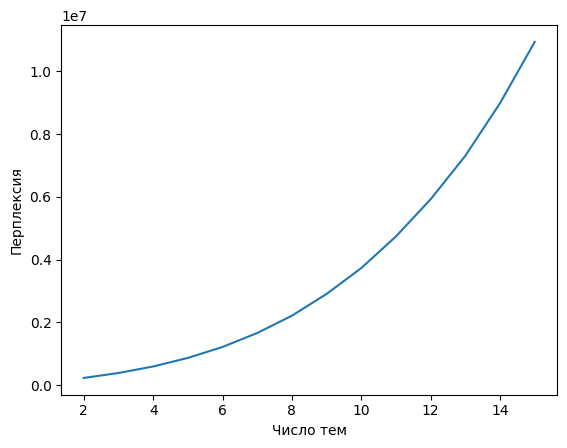

In [ ]:
show_perplexity(pos_vectors)  # график для позитивных отзывов

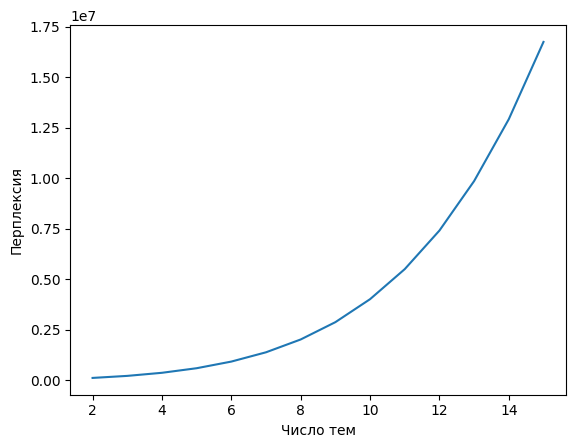

In [ ]:
show_perplexity(neg_vectors) # график для негативных отзывов

Судя по перплексии, модель не может хорошо разделить отзывы по топикам: несмотря на то, что перплексия при заданном количестве топиков не большая, она неуклонно возрастает с добавлением каждого нового топика. Чтобы убедиться в этом, возьмём некоторое число топиков и посмотрим на ключевые n-граммы.

In [ ]:
# определим функцию, которая будет демонстрировать ключевые слова заданного количества топиков:

def plot_top_words(model, feature_names, n_top_words, title, n_components, max_plots):

    fig, axes = plt.subplots(1, max_plots, figsize=(25, 10)) # параметры отображения
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем


    for topic_idx, topic in enumerate(model.components_):
      if topic_idx < max_plots:
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        # строка для сохранения темы и слов в словарь
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 13})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)


    plt.show()

In [ ]:
# позитивные отзывы
lda = LatentDirichletAllocation(n_components=5, random_state=33)
lda.fit(pos_vectors)
pos_feature_names = tfidf_pos.get_feature_names_out()
pos_topic_probabilities = lda.transform(pos_vectors)  # матрица [n_docs, n_topics]
pos_dominant_topics = pos_topic_probabilities.argmax(axis=1) # вектор меток

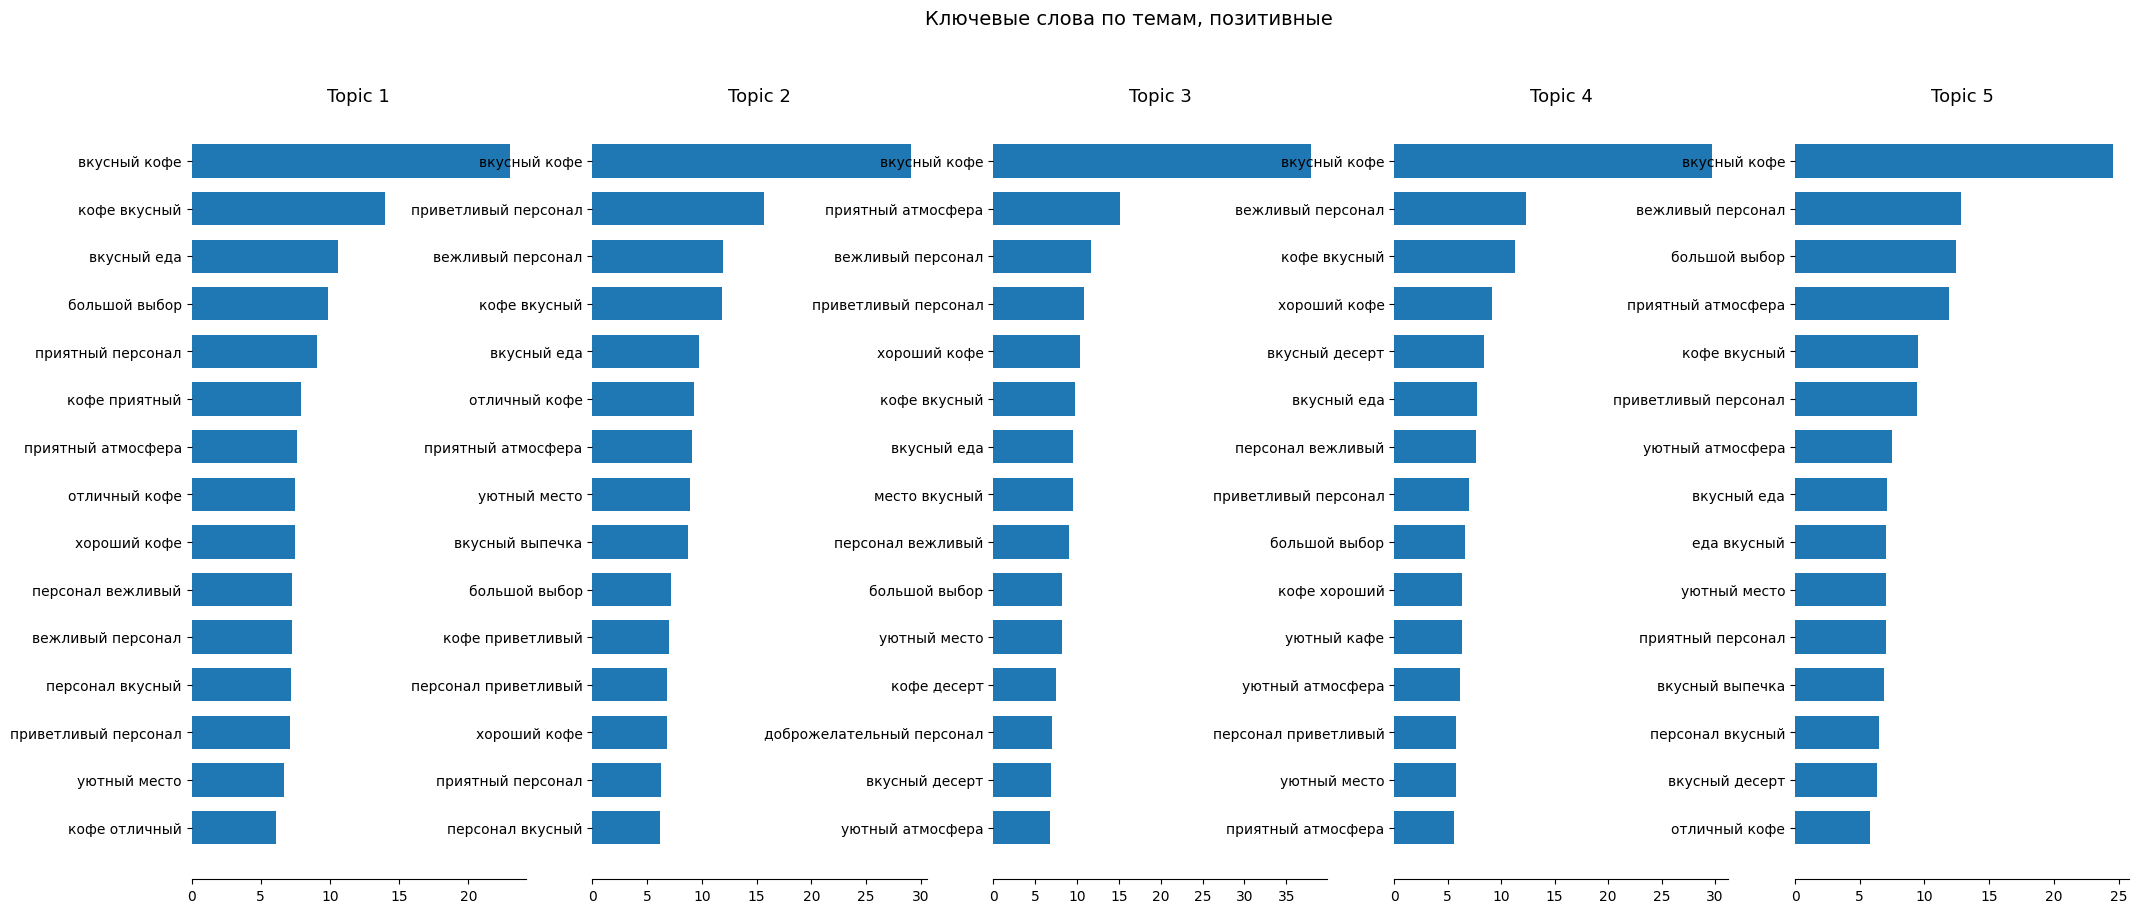

In [ ]:
plot_top_words(lda, pos_feature_names, 15, 'Ключевые слова по темам, позитивные', 5, 5)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=33)
lda.fit(neg_vectors)
neg_feature_names = tfidf_neg.get_feature_names_out()
neg_topic_probabilities = lda.transform(neg_vectors)  # матрица [n_docs, n_topics]
neg_dominant_topics = neg_topic_probabilities.argmax(axis=1)

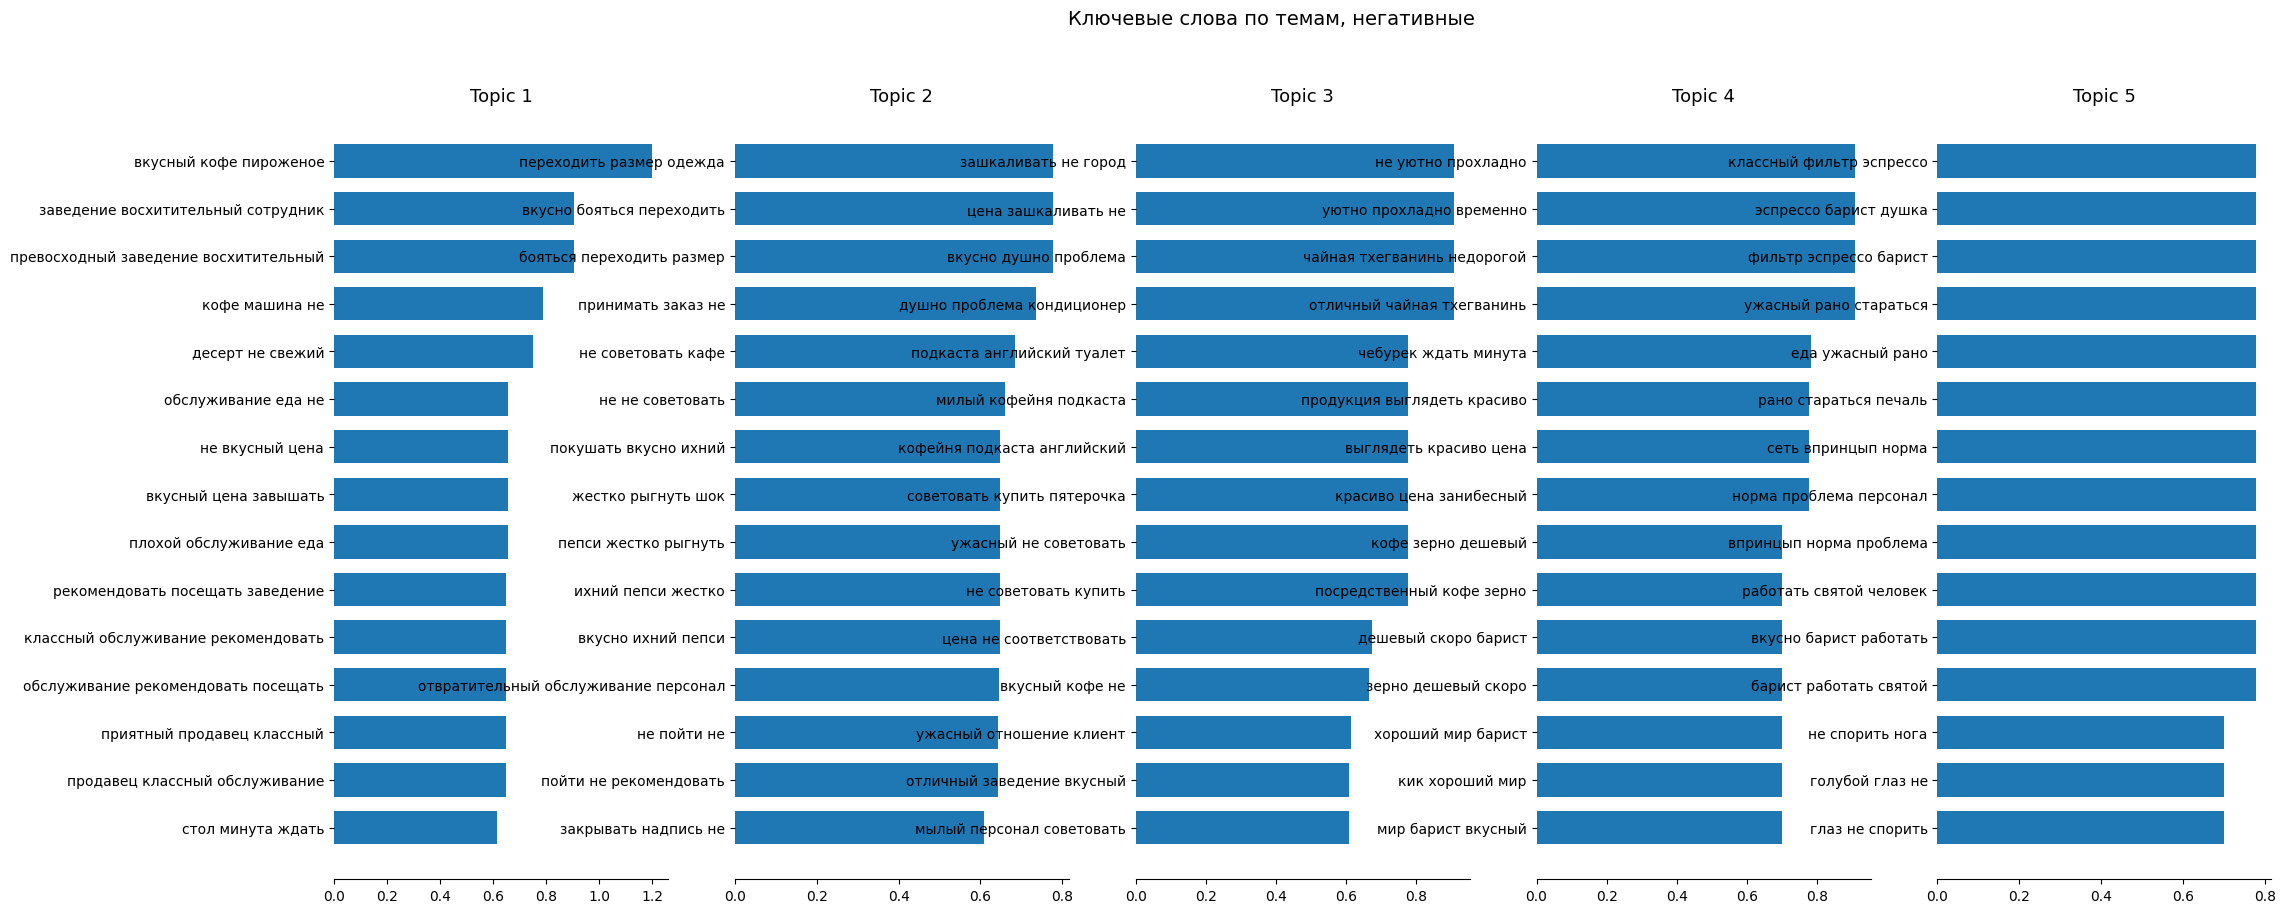

In [ ]:
plot_top_words(lda, neg_feature_names, 15, 'Ключевые слова по темам, негативные', 5, 5)

Проанализировав ключевые n-граммы, можно подтвердить предыдущее предположение о том, что LDA не подходит для разбиения по топикам коротких текстов. Далее визуализируем структуру отзывов для большей наглядности.

## Визуализация отзывов с помощью TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# визуализируем отзывы
def visualize_reviews(reviews_vectors, n_clusters):
  for i in range(2, 53, 10):
    X_embedded = TSNE(n_components=2, init='random', perplexity=i, max_iter=5000).fit_transform(reviews_vectors)
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c=n_clusters)
    plt.title(f'Perplexity={i}')
    plt.show()

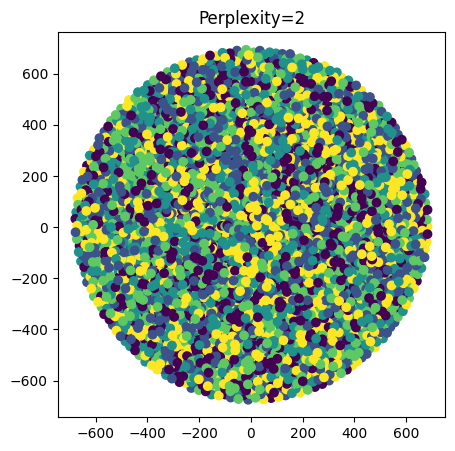

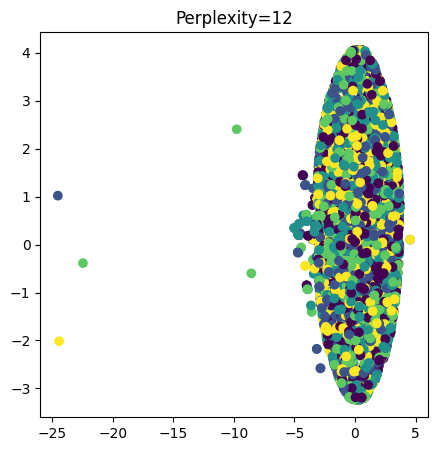

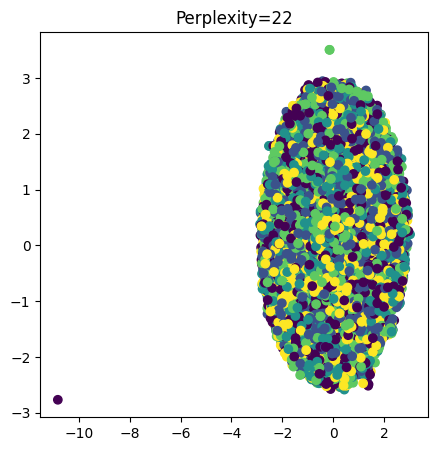

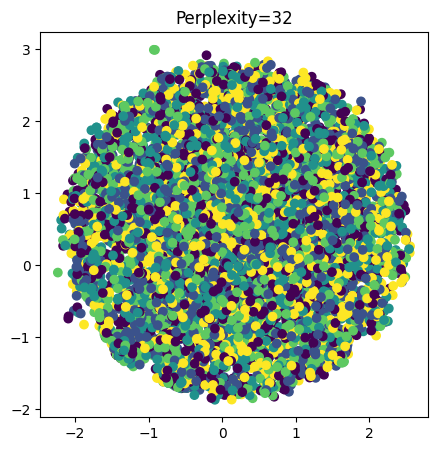

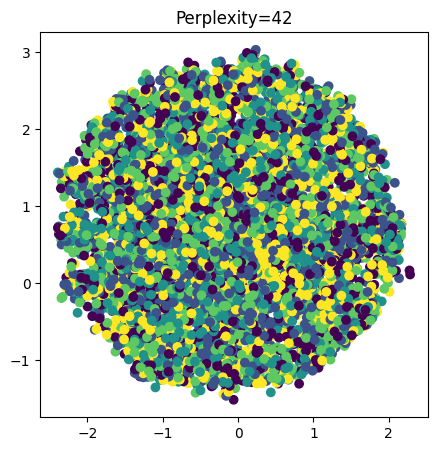

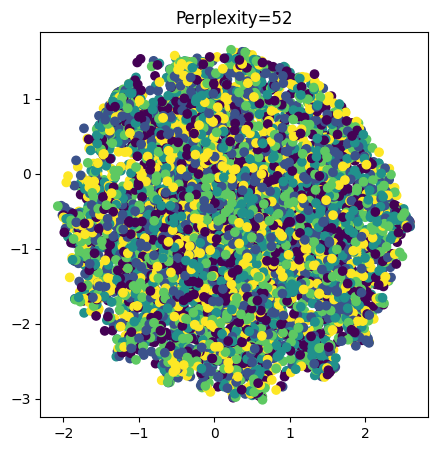

In [ ]:
visualize_reviews(pos_vectors, pos_dominant_topics)  # позитивные отзывы с метками топиков LDA

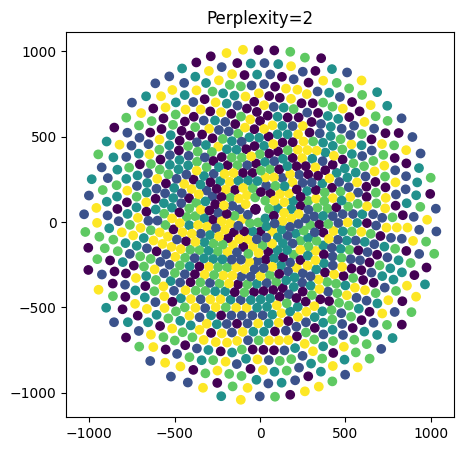

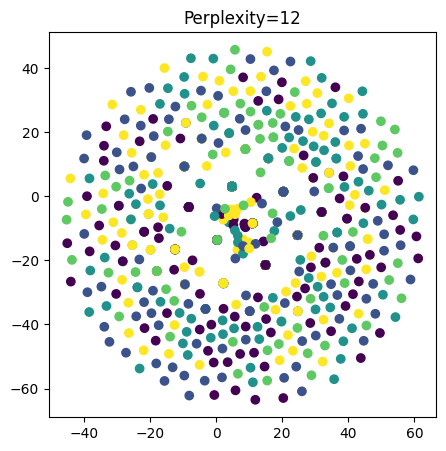

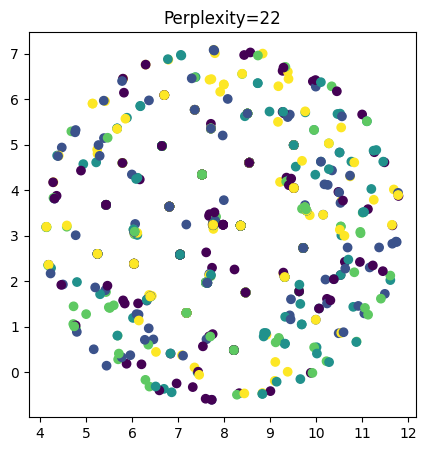

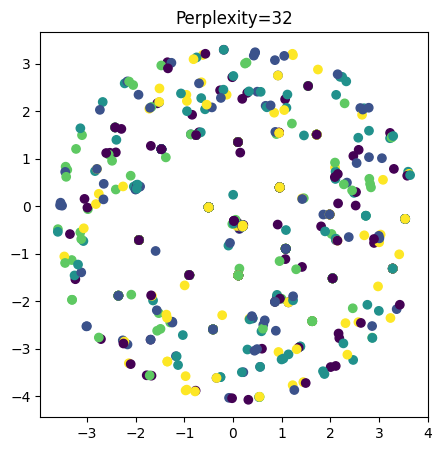

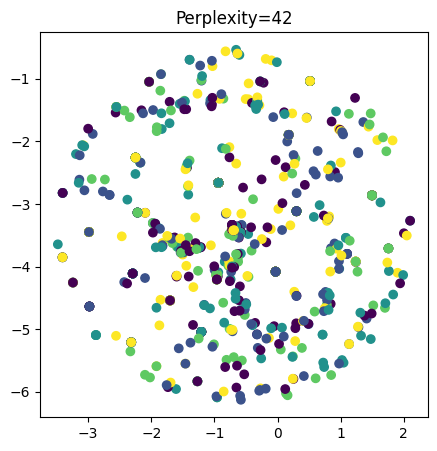

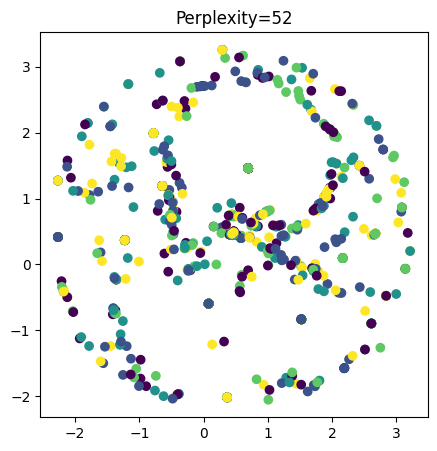

In [ ]:
visualize_reviews(neg_vectors, neg_dominant_topics)   # негативные отзывы с метками топиков LDA

Позитивные отзывы имеют очень плотную структуру как на локальном, так и на глобальном уровне. Локально в данных имеются выбросы, которые могут быть связаны с употреблением сленга или грамматическими ошибками. Видно, что чётких кластеров мы не получили, представители всех кластеров разбросаны разбросаны по всему объёму данных, что можно сказать и про негативные отзывы. Правда здесь уже структура не такая плотная, но это объясняется меньшим количество отзывов.

## Суммаризация отзывов с помощью [T5](https://huggingface.co/RussianNLP/FRED-T5-Summarizer)

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
from transformers import GPT2Tokenizer, T5ForConditionalGeneration
sum_tokenizer = GPT2Tokenizer.from_pretrained('RussianNLP/FRED-T5-Summarizer',eos_token='</s>')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sum_model = T5ForConditionalGeneration.from_pretrained('RussianNLP/FRED-T5-Summarizer').to(device)

Для T5 лемматизация текста будет лишней, используем отзывы как они есть.

In [ ]:
# загрузим сгруппированные на предыдущем этапе отзывы (пока работаем только с негативными, так как их меньше):
positive_reviews_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_reviews.csv', index_col=0)
negative_reviews_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_reviews.csv', index_col=0)
negative_reviews = negative_reviews_df['Отзыв'].tolist()
positive_reviews = positive_reviews_df['Отзыв'].tolist()

In [ ]:
# посмотрим, какая максимальная длина отзывов
check_max_review_length(negative_reviews)

('Максимальная длина отзыва:', 437)

In [ ]:
check_max_review_length(positive_reviews)

('Максимальная длина отзыва:', 538)

Максимальная длина отзывов близка к максимальной длине входа токенайзера (512).

При разбиении отзывов на чанки нейросеть часто проводит суммаризацию только по 1-2 первым отзывам из чанка и упускает из внимания оставшиеся. Учитывая это, будем обрабатывать отзывы по одному, чтобы сохранить максимум информации.

In [ ]:
# определим функцию суммаризации, по которой будет работать модель:
def summarize_texts(prompt, text_list):
    input_text = prompt + " ".join(text_list)
    input_ids=torch.tensor([sum_tokenizer.encode(input_text, max_length=512, truncation=True)]).to(device)
    outputs = sum_model.generate(input_ids,
                                 eos_token_id=sum_tokenizer.eos_token_id,
                                 num_beams=4,
                                 min_new_tokens=10,
                                 max_new_tokens=100,
                                 do_sample=False,
                                 no_repeat_ngram_size=2,
                                 early_stopping=True)
    text_list_summary = sum_tokenizer.decode(outputs[0][1:], skip_special_tokens=True)
    return(text_list_summary)

Работаем с негативными отзывами:

In [ ]:
# сформируем батчи для подачи в модель:
neg_reviews_loader = DataLoader(negative_reviews, batch_size=1)

In [ ]:
# запрос к модели будет таким:
prompt = "<LM> Определи, на что именно жалуется автор. Игнорируй нейтральные или положительные оценки."

In [ ]:
# запускаем алгоритм и собираем результаты:
summary = []
with torch.no_grad():
  for batch in tqdm(neg_reviews_loader):
    batch_summary = summarize_texts(prompt, batch)
    summary.append(batch_summary)

100%|██████████| 966/966 [39:19<00:00,  2.44s/it]


In [ ]:
# сохраним результаты
negative_summary_df = pd.DataFrame(summary)
negative_summary_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_summary_T5.csv')

Теперь обработаем позитивные отзывы

In [ ]:
pos_reviews_loader = DataLoader(positive_reviews, batch_size=4)

In [ ]:
# запрос к модели будет таким:
prompt = "<LM> Определи, что именно понравилось автору отзыва, игнорируй негативные оценки."

In [ ]:
# запускаем алгоритм и собираем результаты:
pos_summary = []
with torch.no_grad():
  for batch in tqdm(pos_reviews_loader):
    batch_summary = summarize_texts(prompt, batch)
    pos_summary.append(batch_summary)

100%|██████████| 2233/2233 [2:03:30<00:00,  3.32s/it]


In [ ]:
# сохраним результаты
positive_summary_df = pd.DataFrame(pos_summary)
positive_summary_df.to_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_summary_T5.csv')

## Частотный анализ и извлечение ключевых фраз из суммаризованных данных

### Нормализация данных

Нормализуем негативные отзывы

In [ ]:
negative_summary_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_summary_T5.csv', index_col=0)
summary = negative_summary_df['0'].tolist()

In [ ]:
# почистим негативные отзывы
neg_reviews_summary = []

for s in summary:
  s = re.sub(r'Автор жалуется на (то, что)?', '', s)
  s = re.sub(r'\n', ' ', s)
  s = re.sub(r'(\d\.|</s>)', '', s)
  s = re.sub(r'\s{2,}', ' ', s)
  neg_reviews_summary.append(s.strip())

In [ ]:
# добавим стоп-слова к имеющемуся списку
stops.update({'также', 'автор', 'описывать'})

In [ ]:
# нормализуем суммаризованные отзывы
neg_summary_normalized = []
for item in neg_reviews_summary:
  neg_summary_normalized.append(normalize(item))

In [ ]:
# расширим список общих фраз
general_phrases += ['не рекомендовать место', 'не соответствовать заявлять', 'не соответствовать ожидание',
                    'рекомендовать место посещение', 'выражать недоумение повод', 'выражать сожаление повод',
                    'отмечать', 'выражать мнение', 'выражать недовольство']

In [ ]:
# определим, как будем отфильтровывать отзывы от общих фраз
def filter_general_phrases_summurized(reviews_list):
  summary_filtered = []

  for review in reviews_list:
    for phrase in general_phrases:
      review = review.replace(phrase, '')
    filtered_review = re.sub(r'\s{2,}', ' ', review)
    summary_filtered.append(filtered_review.strip())

  return(summary_filtered)

In [ ]:
neg_summary_filtered = filter_general_phrases_summurized(neg_summary_normalized)  # негативные отзывы отфильтрованы

Нормализуем позитивные отзывы

In [ ]:
# загружаем отзывы
positive_summary_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_summary_T5.csv', index_col=0)
pos_summary = positive_summary_df['0'].tolist()

In [ ]:
# нормализуем их
pos_summary_normalized = []
for item in pos_summary:
  pos_summary_normalized.append(normalize(item))

In [ ]:
# пополняем список общих фраз
general_phrases += ['оценивать кафе', 'целое оставаться довольный посещение кофейня', 'понравиться кофейня',
                    'понравиться кафе', 'советовать посещать', 'отмечать', 'понравиться']

In [ ]:
pos_summary_filtered = filter_general_phrases_summurized(pos_summary_normalized)  # позитивные отзывы отфильтрованы

Далее извлечём ключи из отзывов с помощью CountVectorizer (он хорошо показал себя с оригинальными отзывами и лучше всего отвечает нашим задачам). И используем полученные n-граммы для оценки суммаризации: посмотрим, насколько хорошо суммаризованный текст передаёт ключевые аспекты оригинальных отзывов. А также ещё раз проверим, подходит ли RAKE для работы с отзывами на суммаризованных данных.

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv_bigram = CountVectorizer(ngram_range=(2,2))  # для позитивных отзывов
cv_trigram = CountVectorizer(ngram_range=(3,3))  # для негативных отзывов

In [ ]:
# извлекаем ключи из негативных суммаризованных отзывов
negative_sum_cv_trigrams = pd.DataFrame(get_main_aspects(neg_summary_filtered, cv_trigram)[:100],
                                        columns=['CV триграммы, суммаризованный текст', 'частота'])

In [ ]:
# а теперь из позитивных
positive_sum_cv_bigrams = pd.DataFrame(get_main_aspects(pos_summary_filtered, cv_bigram)[:100],
                                       columns=['CV биграммы, суммаризованный текст', 'частота'])

In [ ]:
# загрузим датафреймы с ключами оригинальных отзывов:
main_positive_aspects_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_aspects_ORIGINAL.csv', index_col=0)
main_negative_aspects_df = pd.read_csv('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_aspects_ORIGINAL.csv', index_col=0)

In [ ]:
# соединим данные с ключами CountVectorizer
neg_comparative_df = pd.concat([main_negative_aspects_df[['CV триграммы', 'частота']], negative_sum_cv_trigrams], axis=1)

In [ ]:
pos_comparative_df = pd.concat([main_positive_aspects_df[['CV биграммы', 'частота']], positive_sum_cv_bigrams], axis=1)

### RAKE

In [ ]:
pip install rake-nltk

In [ ]:
from rake_nltk import Rake
import nltk
nltk.download('punkt_tab')

In [ ]:
# функция для извлечения ключей
def extract_key_phrases(text, top_n=100):

  r = Rake(min_length=1, max_length=3, include_repeated_phrases=False)
  r.extract_keywords_from_text(text)
  return r.get_ranked_phrases()[:top_n]

In [ ]:
# извлекаем ключи и собираем их в датафрейм
negative_rake_ngrams_sum = pd.DataFrame(extract_key_phrases('. '.join(neg_summary_filtered)), columns=['RAKE n-граммы, суммаризованный текст'])

In [ ]:
positive_rake_ngrams_sum = pd.DataFrame(extract_key_phrases('. '.join(pos_summary_filtered)), columns=['RAKE n-граммы, суммаризованный текст'])

In [ ]:
# смотрим, сколько ключей извлёк алгоритм
len(negative_rake_ngrams_sum), len(positive_rake_ngrams_sum)

(36, 0)

RAKE нашёл уже 38 ключевых n-грамм в негативных отзывах. Но теперь совсем не справился с позитивными.



In [ ]:
# объединяем результаты для сравнения
neg_comparative_df = pd.concat([neg_comparative_df, main_negative_aspects_df['RAKE n-граммы'], negative_rake_ngrams_sum], axis = 1)

In [ ]:
# сохраняем сравнительные таблички
neg_comparative_df.to_excel('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_aspects_comparative.xlsx')
pos_comparative_df.to_excel('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_aspects_comparative.xlsx')

## Оцениваем качество суммаризации с помощью Word2Vec и косинусного сходства

Теперь, когда у нас есть самые частотные n-граммы, полученные с помощью CountVectorizer, оригинальных и суммаризованных отзывов, мы можем сравнить их семантическое сходство. Это позволит нам оценить качество суммаризации.

In [ ]:
neg_comparative_df = pd.read_excel('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Negative_aspects_comparative.xlsx')
pos_comparative_df = pd.read_excel('/content/drive/MyDrive/ВШЭ/ML/Final project/outputs/Positive_aspects_comparative.xlsx')

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# список всех нормализованных отзывов для обучения модели
all_lemmatized_reviews = neg_lemmas_df.tolist() + pos_lemmas_df.tolist() + neg_summary_filtered + pos_summary_filtered

In [ ]:
# Word2Vec работает на уровне слов, поэтому разбиваем отзывы на слова
corpus = []
for review in all_lemmatized_reviews:
  corpus.append(review.split())

In [ ]:
# обучаем модель на корпусе нормализованных отзывов
w2v_model = Word2Vec(corpus, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# определяем, как будем получать векторы n-грамм
def get_ngram_vector(ngram):
  words = ngram.split()  # разбиваем n-грамму на слова
  vectors = []
  for word in words:
   vectors.append(w2v_model.wv[word])
  return sum(vectors) / len(vectors)  # усредняем вектора всех слов в n-грамме

In [ ]:
# получаем списки n-грамм
neg_trigrams_original = neg_comparative_df['CV триграммы'].tolist()
neg_trigrams_summarized = neg_comparative_df['CV триграммы, суммаризованный текст'].tolist()

In [ ]:
pos_bigrams_original = pos_comparative_df['CV биграммы'].tolist()
pos_bigrams_summarized = pos_comparative_df['CV биграммы, суммаризованный текст'].tolist()

In [ ]:
# определим, как будем сравнивать списки n-грамм
def compare_ngram_lists(ngram_list1, ngram_list2):
    # получаем вектора для всех n-грамм в обоих списках
    vectors1 = [get_ngram_vector(ngram) for ngram in ngram_list1]
    vectors2 = [get_ngram_vector(ngram) for ngram in ngram_list2]

    # усредняем все вектора в каждом списке
    avg_vector1 = sum(vectors1) / len(vectors1)
    avg_vector2 = sum(vectors2) / len(vectors2)

    # вычисляем косинусное сходство между усреднёнными векторами
    similarity = cosine_similarity([avg_vector1], [avg_vector2])[0][0]
    return similarity

In [ ]:
print('Косинусное сходство негативных отзывов составляет', round(compare_ngram_lists(neg_trigrams_original, neg_trigrams_summarized), 2))

Косинусное сходство негативных отзывов составляет 0.94


In [ ]:
print('Косинусное сходство позитивных отзывов составляет', round(compare_ngram_lists(pos_bigrams_original, pos_bigrams_summarized), 2))

Косинусное сходство позитивных отзывов составляет 1.0


С помощью модели Word2Vec и вычисления коснусного сходства мы определили, что ключевые n-граммы суммаризованных отзывов на 94-100% передают смысл n-грамм оригинальных отзывов. Это говорит о высоком качестве проведённой суммаризации.